# Jan ??th, 2022 (??)

**Motivation**: ?? <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [12]:
# HIDE CODE


def _coronal(key, obj, t1w, figsize=(13.5, 16)):
    slices = range(21, 66, 4)

    fig, axes = create_figure(4, 3, figsize)
    for i, idx in enumerate(slices):
        ax = axes.flat[i]
        x2plt = np.ma.masked_where(~obj.astype(bool), obj)
        ax.imshow(t1w[..., idx].T, cmap='bone')
        ax.imshow(x2plt[..., idx].T, alpha=1.0, cmap=cmap)
        ax.set_title(f"slice #{idx}")
    sup = fig.suptitle(f"{key}  .  .  .  Coronal", fontsize=17, y=1.02)
    remove_ticks(axes)
    plt.close()
    
    return fig, sup


def _sagittal(key, obj, t1w, figsize=(13.5, 12)):
    slices = range(2, 48, 4)

    fig, axes = create_figure(4, 3, figsize)
    for i, idx in enumerate(slices):
        ax = axes.flat[i]
        x2plt = np.ma.masked_where(~obj.astype(bool), obj)
        ax.imshow(t1w[idx], cmap='bone')
        ax.imshow(x2plt[idx], alpha=1.0, cmap=cmap)
        ax.set_title(f"slice #{idx}")
    sup = fig.suptitle(f"{key}  .  .  .  Sagittal", fontsize=17, y=1.02)
    remove_ticks(axes)
    plt.close()
    
    return fig, sup


def _axial(key, obj, t1w, figsize=(13.5, 13)):
    slices = range(2, 25, 2)

    fig, axes = create_figure(4, 3, figsize)
    for i, idx in enumerate(slices):
        ax = axes.flat[i]
        x2plt = np.ma.masked_where(~obj.astype(bool), obj)
        ax.imshow(t1w[:, idx, :], cmap='bone')
        ax.imshow(x2plt[:, idx, :], alpha=1.0, cmap=cmap)
        ax.set_title(f"slice #{idx}")
    sup = fig.suptitle(f"{key}  .  .  .  Axial", fontsize=17, y=1.02)
    remove_ticks(axes)
    plt.close()
    
    return fig, sup


def _load(mice, key, which: str = 'both', raw_bold: bool = False, space='individual'):
    if which == 'both':
        which = ['ca2', 'bold']
    else:
        which = [which]
    sub, ses, _ = mice.looper[key]
    
    if 'ca2' in which:
        m2d = mice.mask2d[mice.get_key(sub, ses)]
        m2d = m2d.load_ants().numpy().astype(bool)
        x2d = mice.ca_preproc[key][:]
        if x2d is None:
            out2d = None
        else:
            mu2d = x2d.mean(-1)
            sd2d = x2d.std(-1)
            snr2d = mu2d / sd2d
            out2d = {
                'm': m2d,
                'x': x2d,
                'gs': x2d[m2d].mean(0),
                'mu_abs': np.abs(x2d).mean(-1),
                'mu': mu2d,
                'sd': sd2d,
                'snr': snr2d,
                'snr_avg': bn.nanmean(snr2d[m2d]),
            }
    else:
        out2d = None

    if 'bold' in which:
        if raw_bold:
            file = 'Symmetric_N162_0.20.nii.gz'
            file = pjoin(mice.cfg.base_dir, 'Yale', 'atlases_templates', file)
            m3d = ants.image_read(file).numpy().astype(bool)
            try:
                file = next(
                    f for f in os.listdir(mice.cfg.npy_dir) if
                    all(e in f for e in [key, f"space-{space}_desc-raw"])
                )
                file = pjoin(mice.cfg.npy_dir, file)
                x3d = np.load(file)
            except StopIteration:
                x3d = None
        else:
            m3d = mice.mask3d[mice.get_key(sub, ses)]
            m3d = m3d.load_ants().numpy().astype(bool)
            x3d = mice.bold_preproc[key][:]
        if x3d is None:
            out3d = None
        else:
            out3d = x3d
    else:
        out3d = None
        
    return out2d, out3d

In [3]:
mice = Mice((64, 0, 100), load_parcel=True, load_allen=True, full_load=True)

ROI lookup not found, time to run organize_func() . . .

combine metadata not found, time to run cat_data() . . .

In [4]:
# Get stuff from Parcel

cortex = mice.parcel['cortex']
regions = cortex[cortex.nonzero()]
regions = np.unique(regions)
hcl = mice.parcel.decode(regions)


# Random CMAP
rng = get_rng()
num = len(mice.parcel['regions-cortex'])
colors = (
    rng.choice(256, size=num) / 256,
    rng.choice(256, size=num) / 256,
    rng.choice(256, size=num) / 256,
)
colors = list(zip(*colors))
colors = [rgb2hex(c) for c in colors]
cmap = make_cmap(
    ramp_colors=colors,
    name='random_cmap',
    n_colors=num,
    show=False,
)

In [5]:
obj_files = sorted([
    str(e) for e in
    pathlib.Path(mice.cfg.masks_dir).rglob('*_cortex.nii.gz*')
])

t1ws = {}
objs = {}
for key, anat in mice.T1w.items():
    file = next(
        f for f in obj_files
        if key in f
    )
    objs[key] = ants.image_read(
        pjoin(mice.cfg.masks_dir, file),
        pixeltype='unsigned int',
    )
    t1ws[key] = anat.load_ants().numpy()

## 1) T1w

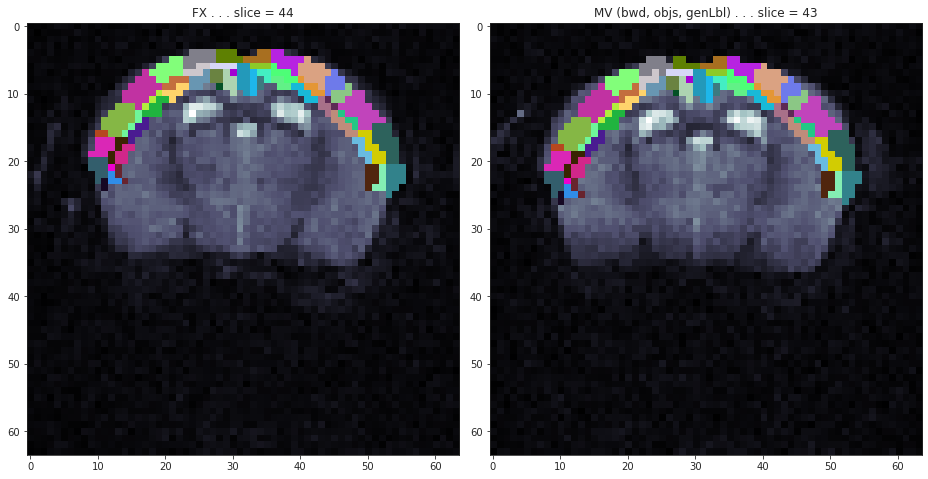

In [105]:
fig, axes = create_figure(1, 2, (13, 8))

key_fx = 'sub-SLC06_ses-2'
key_mv = 'sub-SLC06_ses-3'

ii = 44

axes[0].imshow(t1ws[key_fx][..., ii].T, cmap='bone')
x2plt = np.ma.masked_where(
    objs[key_fx][..., ii] == 0, objs[key_fx][..., ii])
axes[0].imshow(x2plt.T, cmap=cmap)
axes[0].set_title(f'FX . . . slice = {ii}')

jj = ii - 1

axes[1].imshow(t1ws[key_mv][..., jj].T, cmap='bone')
x2plt = np.ma.masked_where(
    objs[key_mv][..., jj] == 0, objs[key_mv][..., jj])
axes[1].imshow(x2plt.T, cmap=cmap)
axes[1].set_title(f'MV (bwd, objs, genLbl) . . . slice = {jj}')
plt.show()

## 2) EPI

In [106]:
_, out_fx = _load(mice, f"{key_fx}_run-3", 'bold', True, 'individual')
_, out_mv = _load(mice, f"{key_mv}_run-3", 'bold', True, 'individual')

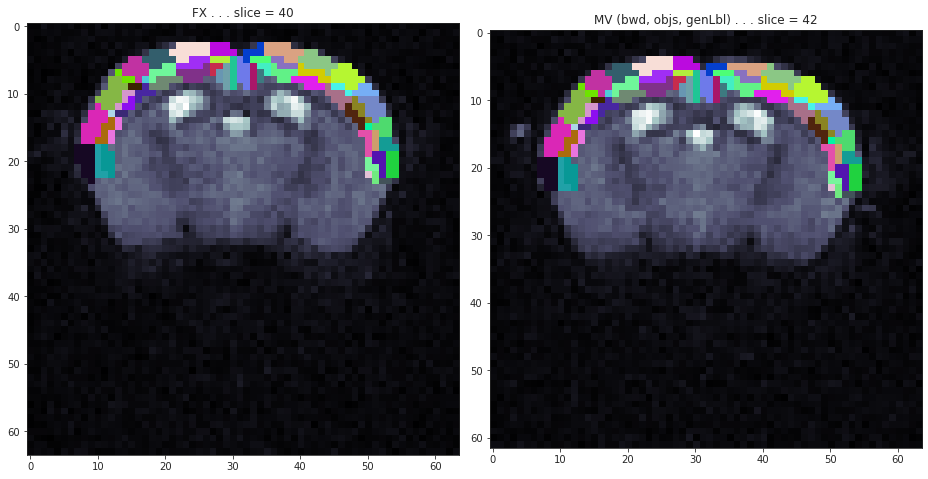

In [107]:
fig, axes = create_figure(1, 2, (13, 8))

key_fx = 'sub-SLC04_ses-2'
key_mv = 'sub-SLC04_ses-3'

ii = 40

axes[0].imshow(t1ws[key_fx][..., ii].T, cmap='bone')
x2plt = np.ma.masked_where(
    objs[key_fx][..., ii] == 0, objs[key_fx][..., ii])
axes[0].imshow(x2plt.T, cmap=cmap)
axes[0].set_title(f'FX . . . slice = {ii}')

jj = ii + 2

axes[1].imshow(t1ws[key_mv][..., jj].T, cmap='bone')
x2plt = np.ma.masked_where(
    objs[key_mv][..., jj] == 0, objs[key_mv][..., jj])
axes[1].imshow(x2plt.T, cmap=cmap)
axes[1].set_title(f'MV (bwd, objs, genLbl) . . . slice = {jj}')

plt.show()

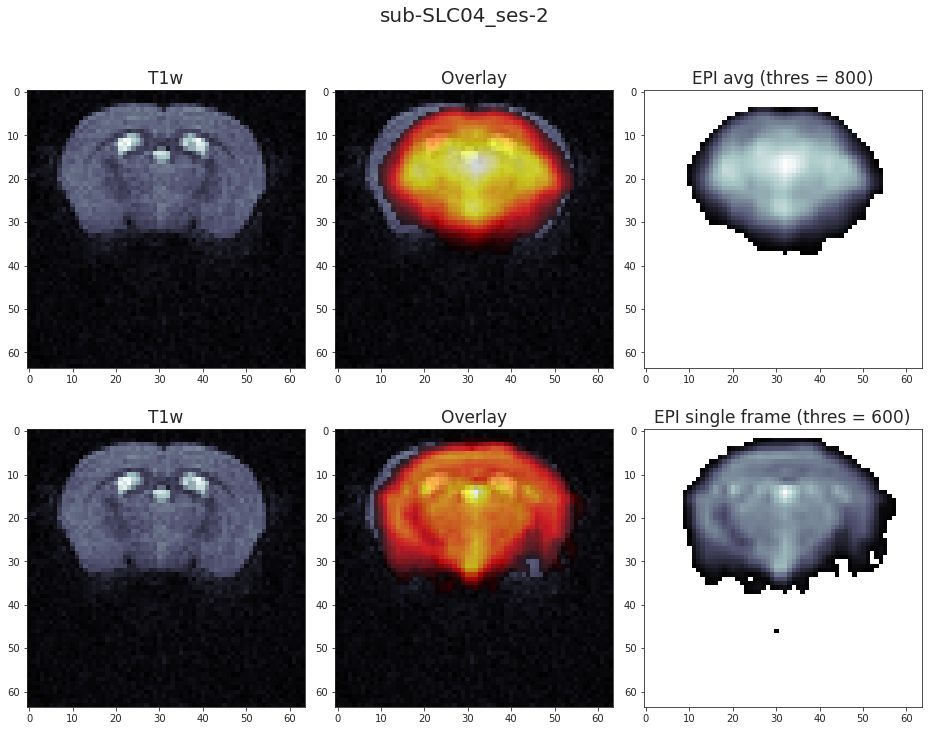

In [129]:
fig, axes = create_figure(2, 3, (13, 10))

for i in range(2):
    axes[i, 0].imshow(t1ws[key_fx][..., ii].T, cmap='bone')
    axes[i, 1].imshow(t1ws[key_fx][..., ii].T, cmap='bone')
    axes[i, 0].set_title('T1w', fontsize=17)
    axes[i, 1].set_title('Overlay', fontsize=17)

thres = 800
x2plt = out_fx[..., 40].mean(-1)
x2plt = np.ma.masked_where(x2plt < thres, x2plt)
axes[0, 2].imshow(x2plt.T, cmap='bone')
axes[0, 1].imshow(x2plt.T, cmap='hot', alpha=0.7)
axes[0, 2].set_title(f"EPI avg (thres = {thres})", fontsize=17)

thres = 600
x2plt = out_fx[..., 40, 120]
x2plt = np.ma.masked_where(x2plt < thres, x2plt)
axes[1, 2].imshow(x2plt.T, cmap='bone')
axes[1, 1].imshow(x2plt.T, cmap='hot', alpha=0.7)
axes[1, 2].set_title(f"EPI single frame (thres = {thres})", fontsize=17)

fig.suptitle(key_fx, fontsize=20, y=1.02)
plt.show()

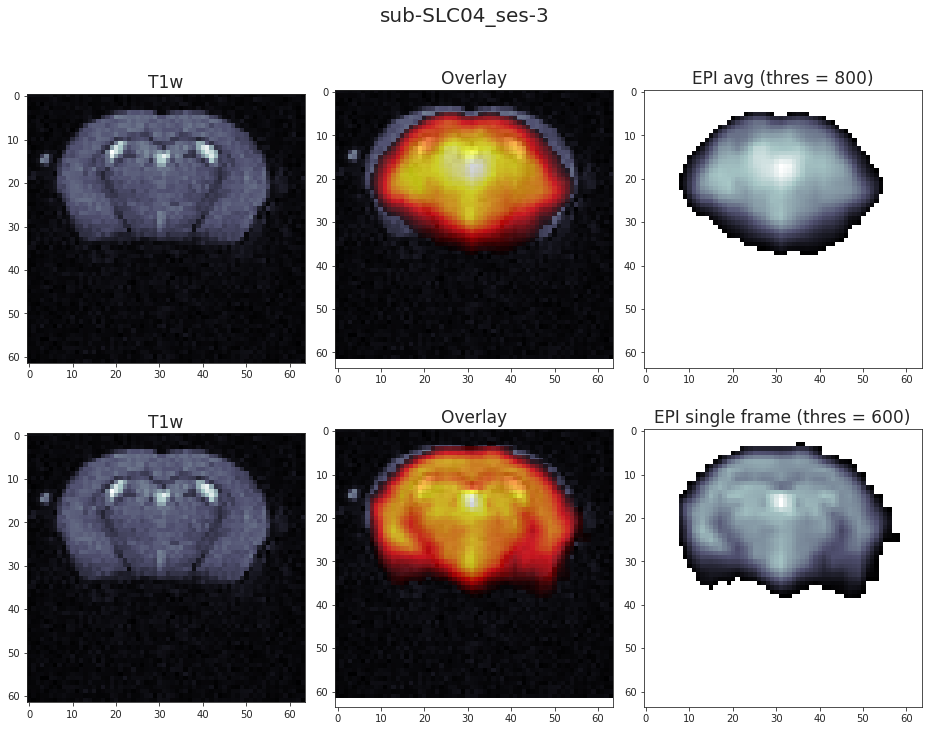

In [126]:
fig, axes = create_figure(2, 3, (13, 10))

for i in range(2):
    axes[i, 0].imshow(t1ws[key_mv][..., ii].T, cmap='bone')
    axes[i, 1].imshow(t1ws[key_mv][..., ii].T, cmap='bone')
    axes[i, 0].set_title('T1w', fontsize=17)
    axes[i, 1].set_title('Overlay', fontsize=17)

thres = 800
x2plt = out_mv[..., 40].mean(-1)
x2plt = np.ma.masked_where(x2plt < thres, x2plt)
axes[0, 2].imshow(x2plt.T, cmap='bone')
axes[0, 1].imshow(x2plt.T, cmap='hot', alpha=0.7)
axes[0, 2].set_title(f"EPI avg (thres = {thres})", fontsize=17)

thres = 600
x2plt = out_mv[..., 40, 120]
x2plt = np.ma.masked_where(x2plt < thres, x2plt)
axes[1, 2].imshow(x2plt.T, cmap='bone')
axes[1, 1].imshow(x2plt.T, cmap='hot', alpha=0.7)
axes[1, 2].set_title(f"EPI single frame (thres = {thres})", fontsize=17)

fig.suptitle(key_mv, fontsize=20, y=1.02)
plt.show()